<a href="https://colab.research.google.com/github/ndn1954/CNN-Car-Model-Detector/blob/main/Car_Model_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect car model available in India. Here car model of 71 different types are trained to detect the right model.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##### Loading Car Image Data

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/Project/car_model_detector/images/")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Project/car_model_detector/images/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

3313
3313


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (180, 180)
num_classes = 71

Use 80% of the images for training, and 20% for validation.

In [6]:
## Train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="training",
                                                               seed=123,image_size=image_size,batch_size=batch_size,)

Found 38814 files belonging to 71 classes.
Using 31052 files for training.


In [7]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",
                                                               seed=123,image_size=image_size,batch_size=batch_size,)

Found 38814 files belonging to 71 classes.
Using 7762 files for validation.


In [8]:
# List out all the classes of Cars and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['Ford_EcoSport', 'Ford_Figo', 'Honda_Amaze', 'Honda_BRV', 'Honda_Brio', 'Honda_City', 'Honda_Civic', 'Honda_Jazz', 'Honda_WRV', 'Hyundai_Accent', 'Hyundai_Creta', 'Hyundai_Elantra', 'Hyundai_Elitei20', 'Hyundai_Eon', 'Hyundai_Getz', 'Hyundai_Grand_i10', 'Hyundai_SantaFe', 'Hyundai_Santro', 'Hyundai_Sonata', 'Hyundai_Terracan', 'Hyundai_Tuscon', 'Hyundai_Verna', 'Hyundai_Xcent', 'Hyundai_i10', 'Hyundai_i20', 'Hyundai_i20Active', 'Kia_Seltos', 'MG_Hector', 'Mahindra_AlturasG4', 'Mahindra_Bolero', 'Mahindra_KUV100', 'Mahindra_Marazzo', 'Mahindra_Scorpio', 'Mahindra_TUV300', 'Mahindra_Thar', 'Mahindra_Verito', 'Mahindra_XUV300', 'Mahindra_XUV500', 'Mahindra_e2o', 'Maruti_Alto800', 'Maruti_AltoK10', 'Maruti_Baleno', 'Maruti_Brezza', 'Maruti_Celerio', 'Maruti_Ciaz', 'Maruti_Eeco', 'Maruti_Ertiga', 'Maruti_Ignis', 'Maruti_SCross', 'Maruti_Swift', 'Maruti_SwiftDzire', 'Maruti_WagonR', 'Tata_Aria', 'Tata_Bolt', 'Tata_Harrier', 'Tata_Hexa', 'Tata_Indica', 'Tata_Nano', 'Tata_Nexon', 'Tata_Safari

##### Delete images which are not in right format

In [ ]:
num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/Project/car_model_detector/images/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            #print(fpath)
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

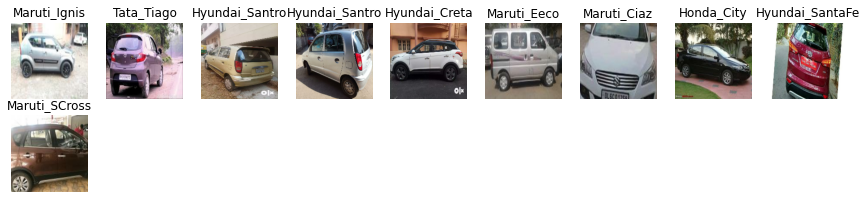

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(9, 9, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

3313


##### Define Model

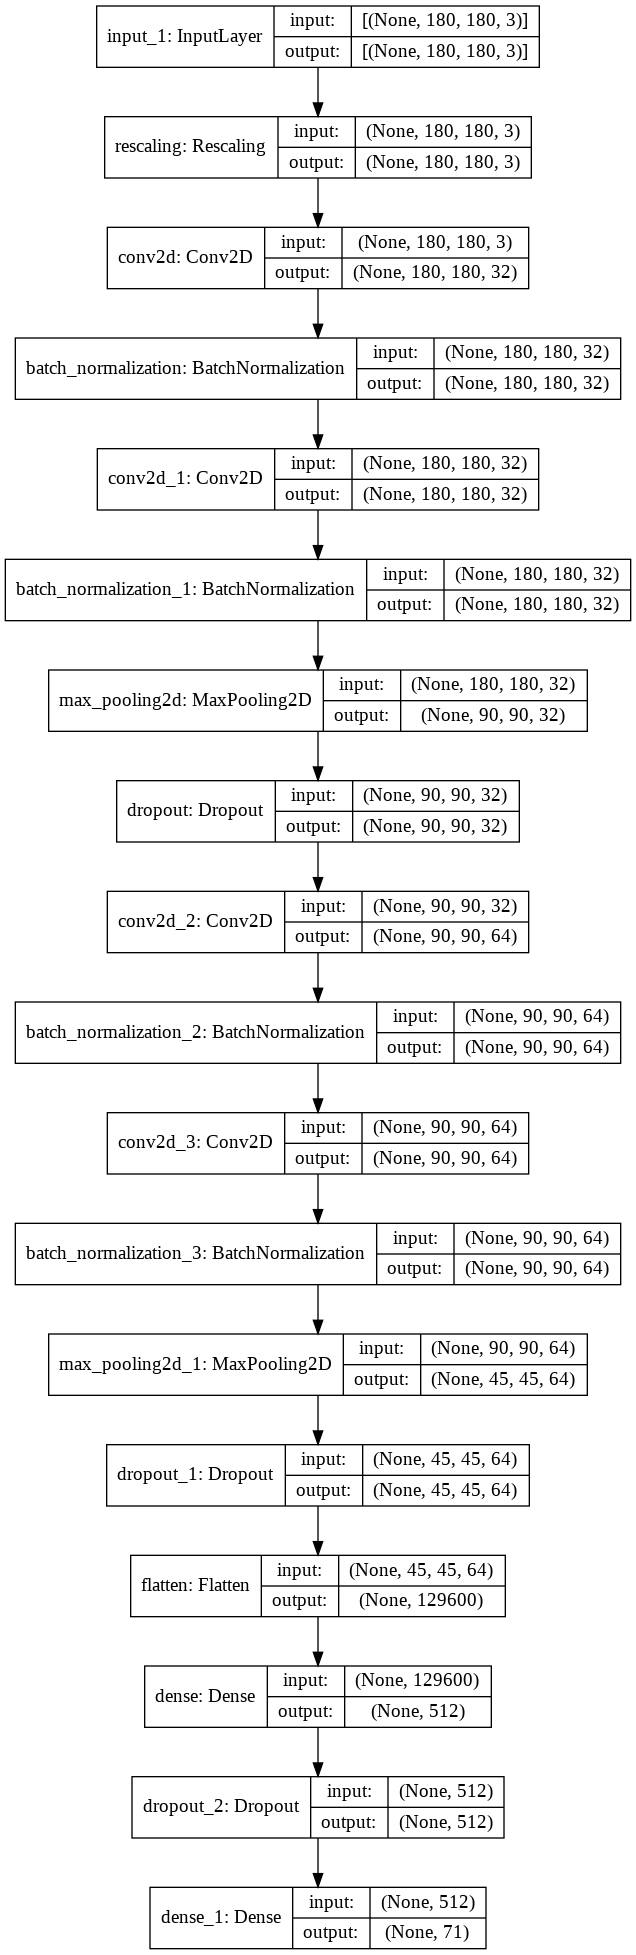

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Rescaling
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(32, 3, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512,activation='relu')(x)

    x = layers.Dropout(0.3)(x)

    x = layers.Dense(num_classes,activation='softmax')(x)
    return keras.Model(inputs, x)

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

#### Compile the Model

In [10]:
## your code goes here
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### Train the Model

In [12]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
971/971 [==============================] - 8795s 9s/step - loss: 4.0736 - accuracy: 0.1846 - val_loss: 1.2462 - val_accuracy: 0.6873
Epoch 2/10
971/971 [==============================] - 182s 187ms/step - loss: 0.9002 - accuracy: 0.7670 - val_loss: 0.3560 - val_accuracy: 0.9092
Epoch 3/10
971/971 [==============================] - 180s 185ms/step - loss: 0.2422 - accuracy: 0.9325 - val_loss: 0.1728 - val_accuracy: 0.9584
Epoch 4/10
971/971 [==============================] - 180s 185ms/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.1598 - val_accuracy: 0.9634
Epoch 5/10
971/971 [==============================] - 179s 184ms/step - loss: 0.0563 - accuracy: 0.9852 - val_loss: 0.1332 - val_accuracy: 0.9688
Epoch 6/10
971/971 [==============================] - 180s 185ms/step - loss: 0.0378 - accuracy: 0.9901 - val_loss: 0.1395 - val_accuracy: 0.9678
Epoch 7/10
971/971 [==============================] - 181s 186ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.1413 - v

#### Visualize accuracy from history

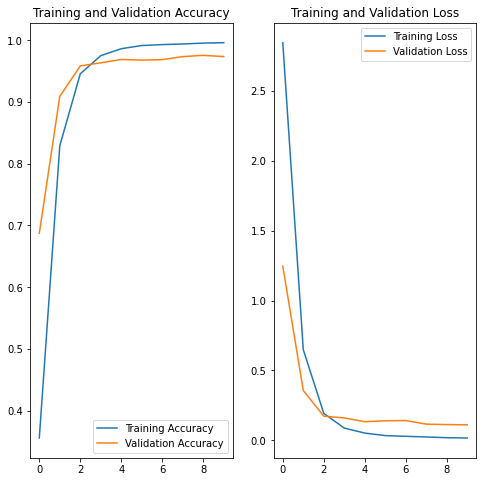

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=image_size,batch_size=batch_size,)
loss, acc = model_with_normalization.evaluate(test_ds,verbose=1)

In [ ]:
print("Test: accuracy = %f  ;  loss = %f" % (acc, loss))